##IMPORTS

In [2]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"using device: {device}")

using device: cuda


##DATA PREPROCESSING AND CREATION

In [4]:
#creating dataframe
# df=pd.read_csv("/content/fmnist_small.csv")
df=pd.read_csv("/content/fashion-mnist_train.csv")

In [5]:
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.shape

(60000, 785)

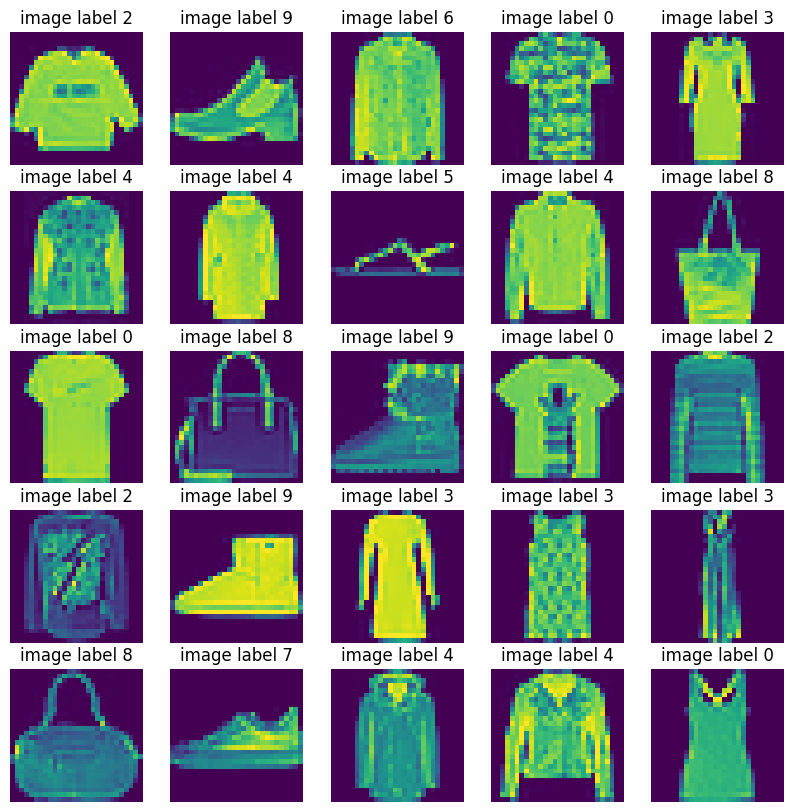

In [7]:
#viewing dataset
fig, axes=plt.subplots(5, 5, figsize=(10,10))
for i,ax in enumerate(axes.flat):
  img=df.iloc[i,1:].values.reshape(28,28)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title(f'image label {df.iloc[i,0]}')
plt.show()

In [8]:
#preparing data for training/testing
# .values converts df into a np array
x=df.iloc[:,1:].values
y=df.iloc[:,0].values

In [9]:
type(x)

numpy.ndarray

In [10]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8,test_size=0.2)

In [11]:
#scalin images
x_train=x_train/255
x_test=x_test/255

In [12]:
#CREATING CUSTOM DATASET
class CustomDataset(Dataset):
  def __init__(self, features, labels):
    self.features=torch.tensor(features,dtype=torch.float32)
    self.labels=torch.tensor(labels,dtype=torch.long)

  def __len__(self):
    return self.features.shape[0]

  def __getitem__(self,index):
    return self.features[index], self.labels[index]

In [13]:
#create onjects using custom dataset
train_dataset=CustomDataset(x_train,y_train)
test_dataset=CustomDataset(x_test,y_test)

In [14]:
print(len(train_dataset))
print(len(test_dataset))

48000
12000


In [15]:
#create dataloaders
test_loader=DataLoader(dataset=test_dataset,batch_size=128,shuffle=False,pin_memory=True)
train_loader=DataLoader(dataset=train_dataset,batch_size=128,shuffle=True,pin_memory=True)

##Building the Model

In [17]:
#OVERFITTING SOLUTIONS:
#1.dropout is applied on hidden layers only
#2.batch normalization(revise what it does), applied after layer before activation
#3.regularization(l2): adding penalty value to shift minimization from just loss to loss+penalty
class NN(nn.Module):
  def __init__(self,num_features):
    super().__init__()
    self.model=nn.Sequential(
        nn.Linear(num_features,128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(128,64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(p=0.3),
        nn.Linear(64,10)
        #dont have to add softmax explicitlly cause pytorch has softmax included by default in cross entropy loss.
    )

  def forward(self,x):
    return self.model(x)

In [50]:
#learning rate and epochs
learning_rate=0.005
epochs=50

In [51]:
x_train.shape

(48000, 784)

In [52]:
#initialize the model
model=NN(x_train.shape[1])
model=model.to(device)

In [53]:
#visualize the model
from torchsummary import summary
summary(model,input_size=(x_train.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
       BatchNorm1d-6                   [-1, 64]             128
              ReLU-7                   [-1, 64]               0
           Dropout-8                   [-1, 64]               0
            Linear-9                   [-1, 10]             650
Total params: 109,770
Trainable params: 109,770
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.42
Estimated Total Size (MB): 0.43
-------------------------------------------

In [54]:
#initializing loss and optimizer
loss_function=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-4)
#weight_decay=lambda, sets l2 regularization

In [55]:
#training loop
for epoch in range(epochs):
  total_loss=0
  for x,y in train_loader:
    x=x.to(device)
    y=y.to(device)
    y_pred=model(x)
    loss=loss_function(y_pred,y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss=total_loss+loss.item()
  print(f"Epoch: {epoch+1}, Loss: {total_loss/len(train_loader)}")

Epoch: 1, Loss: 0.586057115872701
Epoch: 2, Loss: 0.45683202771345777
Epoch: 3, Loss: 0.4233792955080668
Epoch: 4, Loss: 0.41544235702355703
Epoch: 5, Loss: 0.4036929212411245
Epoch: 6, Loss: 0.39208084670702614
Epoch: 7, Loss: 0.38832712117830914
Epoch: 8, Loss: 0.38310963145891824
Epoch: 9, Loss: 0.3847879771391551
Epoch: 10, Loss: 0.38086073521773023
Epoch: 11, Loss: 0.377768493493398
Epoch: 12, Loss: 0.37764106853803
Epoch: 13, Loss: 0.37961477967103324
Epoch: 14, Loss: 0.37038057788213097
Epoch: 15, Loss: 0.3730200343926748
Epoch: 16, Loss: 0.3707762901385625
Epoch: 17, Loss: 0.37051360205809275
Epoch: 18, Loss: 0.3689473127921422
Epoch: 19, Loss: 0.36734288501739504
Epoch: 20, Loss: 0.3705446352163951
Epoch: 21, Loss: 0.36707018411159514
Epoch: 22, Loss: 0.3651947387854258
Epoch: 23, Loss: 0.36625874280929566
Epoch: 24, Loss: 0.3668088872432709
Epoch: 25, Loss: 0.3667350093921026
Epoch: 26, Loss: 0.36770979062716164
Epoch: 27, Loss: 0.3640823504924774
Epoch: 28, Loss: 0.359658170

In [56]:
model.eval()

NN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [57]:
correct=0
total=0
with torch.no_grad():
  for batch_features, batch_labels in test_loader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    batch_pred=model(batch_features)
    what, label_pred= torch.max(batch_pred,axis=1)
    total=total+batch_labels.shape[0]
    correct=correct+(label_pred==batch_labels).sum().item()
print(f"Test Data Accuracy: {correct/total:.4f}")

correct=0
total=0
with torch.no_grad():
  for batch_features, batch_labels in train_loader:
    batch_features,batch_labels=batch_features.to(device),batch_labels.to(device)
    batch_pred=model(batch_features)
    what, label_pred= torch.max(batch_pred,axis=1)
    total=total+batch_labels.shape[0]
    correct=correct+(label_pred==batch_labels).sum().item()
print(f"Training Data Accuracy: {correct/total:.4f}")

Test Data Accuracy: 0.8595
Training Data Accuracy: 0.8842


##Hyperparameter tuning using OPTUNA

In [40]:
class mynn(nn.Module):
  def __init__(self,input_dim,output_dim,hidden_layers,neurons_per_layer,dropout_prob):
    super().__init__()
    layers=[]
    for i in range(hidden_layers):
      layers.append(nn.Linear(input_dim,neurons_per_layer))
      layers.append(nn.BatchNorm1d(neurons_per_layer))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(p=dropout_prob))
      input_dim=neurons_per_layer

    layers.append(nn.Linear(input_dim,output_dim))
    self.model=nn.Sequential(*layers)

  def forward(self,x):
    return self.model(x)

In [41]:
model=mynn(input_dim=784,output_dim=10,hidden_layers=2,neurons_per_layer=128,dropout_prob=0.3)
from torchsummary import summary
summary=summary(model=model,input_size=(784,))

RuntimeError: Expected all tensors to be on the same device, but got mat1 is on cuda:0, different from other tensors on cpu (when checking argument in method wrapper_CUDA_addmm)

In [48]:
def objective(trial):
  #pick hyperparameter value from search space
  num_hidden_layers=trial.suggest_int("num_hidden_layers",1,5)
  num_neurons_per_layer=trial.suggest_int("num_neurons_per_layer",8,128,step=8)
  epochs=trial.suggest_int("epochs",10,50,step=10)
  learning_rate=trial.suggest_float("lr",1e-5,1e-1,log=True)
  dropout_prob=trial.suggest_float("dropout_prob",0.1,0.5,step=0.1)
  weight_decay=trial.suggest_float("weight_decay",1e-5,1e-3,log=True)
  optimizer_name=trial.suggest_categorical("optimizer",["adam","sgd"])


  #model initialization
  model=mynn(input_dim=784,output_dim=10,hidden_layers=num_hidden_layers,neurons_per_layer=num_neurons_per_layer,dropout_prob=dropout_prob)
  model=model.to(device)

  #set optimizer and loss
  if optimizer_name=="adam":
    optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
  else:
    optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate,weight_decay=weight_decay)
  loss_func=nn.CrossEntropyLoss()

  #training loop
  for epoch in range(epochs):
    for features, labels in train_loader:
      #shift tensors to device
      #predict
      #compute loss
      #clear grads: optimizer.zero_grad_()
      #backprop: loss.backward()
      #weight update: optimizer.step()
      features = features.to(device)
      labels = labels.to(device)
      y_pred=model(features)
      loss=loss_func(y_pred,labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

  #evaluation on test data
  model.eval()
  total,correct=0,0
  with torch.no_grad():

    for batch_features, batch_labels in test_loader:

      # move data to gpu
      batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

      outputs = model(batch_features)

      _, predicted = torch.max(outputs, 1)

      total = total + batch_labels.shape[0]

      correct = correct + (predicted == batch_labels).sum().item()

    accuracy = correct/total

  return accuracy

In [49]:
!pip install optuna

In [50]:
import optuna
study=optuna.create_study(study_name="learning_optuna",direction='maximize')

[I 2025-09-01 09:34:41,703] A new study created in memory with name: learning_optuna


In [51]:
study.optimize(objective,n_trials=10)

[I 2025-09-01 09:35:04,665] Trial 0 finished with value: 0.8668333333333333 and parameters: {'num_hidden_layers': 1, 'num_neurons_per_layer': 40, 'epochs': 20, 'lr': 0.024090948363840337, 'dropout_prob': 0.2, 'weight_decay': 0.00014449470211660238, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.8668333333333333.
[I 2025-09-01 09:35:17,915] Trial 1 finished with value: 0.7765833333333333 and parameters: {'num_hidden_layers': 4, 'num_neurons_per_layer': 48, 'epochs': 10, 'lr': 0.0020320694600886287, 'dropout_prob': 0.30000000000000004, 'weight_decay': 7.864447574118341e-05, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.8668333333333333.
[I 2025-09-01 09:36:03,210] Trial 2 finished with value: 0.86825 and parameters: {'num_hidden_layers': 2, 'num_neurons_per_layer': 88, 'epochs': 40, 'lr': 2.5511439804799164e-05, 'dropout_prob': 0.30000000000000004, 'weight_decay': 2.9082828574032716e-05, 'optimizer': 'adam'}. Best is trial 2 with value: 0.86825.
[I 2025-09-01 09:36:47,756] Trial

In [52]:
study.best_value

0.8718333333333333

In [53]:
study.best_params

{'num_hidden_layers': 3,
 'num_neurons_per_layer': 120,
 'epochs': 10,
 'lr': 0.0034828478873113067,
 'dropout_prob': 0.5,
 'weight_decay': 3.641540577622832e-05,
 'optimizer': 'adam'}

In [54]:
study.best_trial

FrozenTrial(number=8, state=1, values=[0.8718333333333333], datetime_start=datetime.datetime(2025, 9, 1, 9, 39, 6, 652783), datetime_complete=datetime.datetime(2025, 9, 1, 9, 39, 19, 526751), params={'num_hidden_layers': 3, 'num_neurons_per_layer': 120, 'epochs': 10, 'lr': 0.0034828478873113067, 'dropout_prob': 0.5, 'weight_decay': 3.641540577622832e-05, 'optimizer': 'adam'}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_hidden_layers': IntDistribution(high=5, log=False, low=1, step=1), 'num_neurons_per_layer': IntDistribution(high=128, log=False, low=8, step=8), 'epochs': IntDistribution(high=50, log=False, low=10, step=10), 'lr': FloatDistribution(high=0.1, log=True, low=1e-05, step=None), 'dropout_prob': FloatDistribution(high=0.5, log=False, low=0.1, step=0.1), 'weight_decay': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'optimizer': CategoricalDistribution(choices=('adam', 'sgd'))}, trial_id=8, value=None)